# DATA 604 HW5

Magnus Skonberg | June 23rd 2021

These exercises and their solutions were made with reference to *Modeling and Simulation in Python* (version 3) authored by Allen B. Downey. This week's exercises focused on **Case Studies**, chapters 10 and 11 of the text.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

## Chapter 10

### Background

On the Wikipedia page about world population estimates, the first table contains estimates for prehistoric populations. The following cells process this table and plot some of the results.

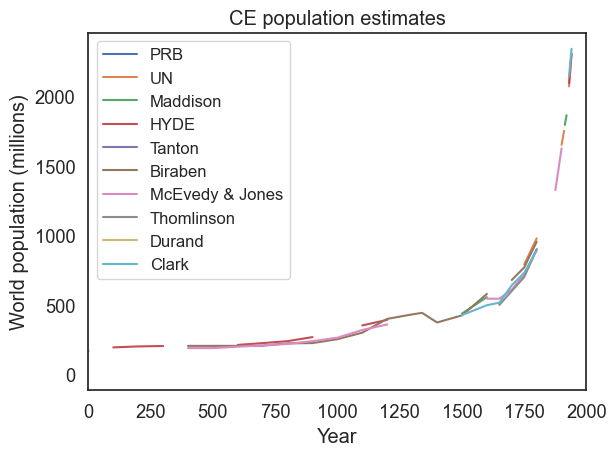

In [2]:
#read in data from Wikipedia
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table1 = tables[1]

#replace long column names with shortened form:
table1.columns = ['PRB', 'UN', 'Maddison', 'HYDE', 'Tanton', 
                  'Biraben', 'McEvedy & Jones', 'Thomlinson', 'Durand', 'Clark']

#Coerce column entries to numeric
for col in table1.columns:
    table1[col] = pd.to_numeric(table1[col], errors='coerce')

#Plot our table
#table1.plot()
#decorate(xlim=[-10000, 2000], xlabel='Year', 
#         ylabel='World population (millions)',
#         title='Prehistoric population estimates')
#plt.legend(fontsize='small');

#Use `xlim` to zoom in on everything after Year 0.
table1.plot()
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='CE population estimates')
plt.legend(fontsize='small');

### Optional Exercise

See if you can find a model that fits these data well from Year 0 to 1950.

How well does your best model predict actual population growth from 1950 to the present?

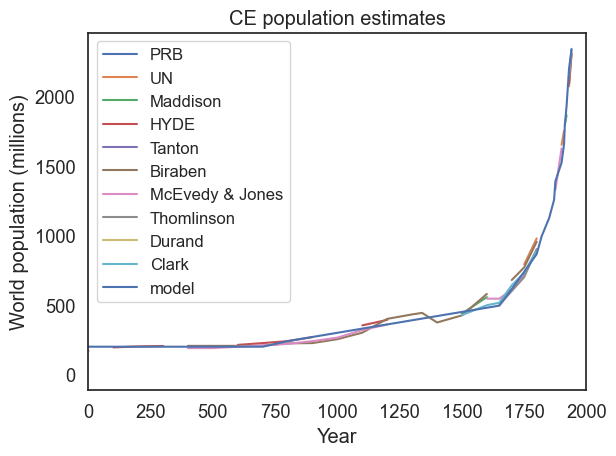

In [3]:
#Pt1: See if you can find a model that fits these data well from Year 0 to 1950.

#declare variables
alpha1 = 0.3
alpha2 = 3.525 / 50 #slope from 1700 thru 1900 divided by constant varied until output matched desire
model_list = []

#iterate through each year entry
for i in table1.index:
    if i <= 700:
        model_list.append(200)
    elif i > 700 and i < 1700: 
        model_list.append(alpha1 * i ) #slight growth - linear
    else: #beyond 1700
        model_list.append(alpha2 * i + model_list[-1]) 

table1['model'] = model_list

table1.plot()
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='CE population estimates')
plt.legend(fontsize='small');


I observed that the population seemed to grow at varied rates during different time periods:
* upto the year 700 the population was stable / constant about 200 mil
* from 700 to 1700 the population grew at a slight rate (`alpha1`)
* from 1700 onward the population grew at a faster rate and so we added the population from the entry prior and reduced the value of our multiplier (`alpha2`)

I then observed how this model performed on data from 1950 onward:

Year
1950    2.557629
1951    2.626401
1952    2.695209
1953    2.764053
1954    2.832931
          ...   
2012    6.888197
2013    6.959155
2014    7.030149
2015    7.101177
2016    7.172241
Name: model, Length: 67, dtype: float64

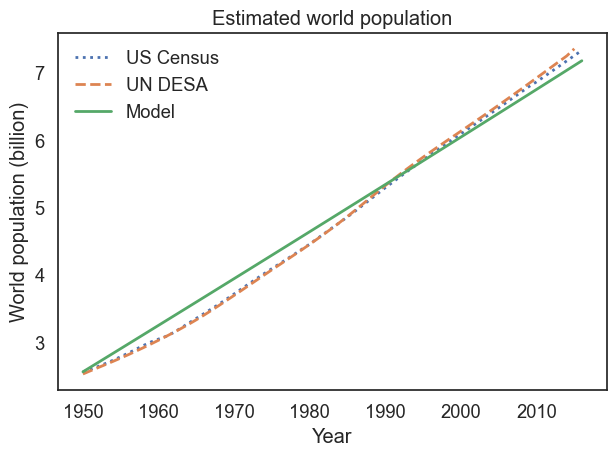

In [4]:
# How well does your best model predict actual population growth from 1950 to the present?

#extract proper data
table2 = tables[2]

#replace long column names with shortened form:
table2.columns = ['census', 'PRB', 'un', 'Maddison', 'HYDE', 'Tanton', 
                  'Biraben', 'McEvedy & Jones', 'Thomlinson', 'Durand', 'Clark']

#declare variables
alpha2 = 3.525 / 50 #slope from 1700 thru 1900 divided by constant varied until output matched desire
model_list = []
un = table2.un / 1e9
census = table2.census / 1e9

#iterate through each year entry
for i in table2.index:
    if i == 1950:
        model_list.append(get_first_value(census))
    else:
        model_list.append(model_list[-1] + (alpha2 * i) / 2000) #convert millions to billions

table2['model'] = model_list


model = table2.model

plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
plot(model, '-', label='Model')
    
decorate(xlabel='Year', 
         ylabel='World population (billion)',
         title='Estimated world population')

#model

#Kernel>Restart & Run All (to update/run)

The same code snippet used upto the year 1950 was applied post-1950 (with a conversion factor) and the result above shows that, while limited and certainly general, the equation (`model_list[-1] + (alpha2 * i) / 2000`) generates a relatively accurate model.

## Chapter 11

### SIR Implementation

**Exercise** Suppose the time between contacts is 4 days and the recovery time is 5 days. After 14 weeks, how many students, total, have been infected?

*Hint: what is the change in S between the beginning and the end of the simulation?*

In [19]:

init = State(S=89, I=1, R=0) #generate state variable
init /= sum(init) #convert from number to fraction

def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14 #14 weeks

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

tc = 4      # time between contacts in days 
tr = 5      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

#take the state during the current time step and return the state during the next time step
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

def run_simulation(system, update_func): #call update function for each time step
    """Runs a simulation of the system.
    
    system: System object
    update_func: function that updates state
    
    returns: State object for final state
    """
    state = system.init
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, t, system)
        
    return state

final = run_simulation(system, update_func) #the state of the system at t_end

#How many students have been infected?
(init.S - final.S) * 90 #the opposite of how many haven't

34.08459698173313

Provided a time between contacts of 4 days and recovery time of 5 days, after 14 weeks, 34 students will have been infected.

### Using a DataFrame

**Exercise**  Suppose the time between contacts is 4 days and the recovery time is 5 days.  Simulate this scenario for 14 weeks and plot the results.

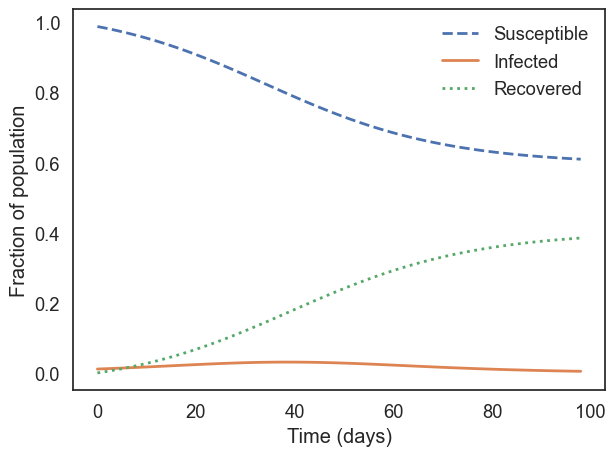

In [21]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

tc = 4      # time between contacts in days 
tr = 5      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
results = run_simulation(system, update_func)
results.head()

plot_results(results.S, results.I, results.R)